## Rignot basins on a 16 km BISICLES grid

The Rignot basin files from IMBIE come as a shape file. This notebook converts the shape file into a netcdf set onto the BISICLES 16 km grid.

In [1]:
import xarray as xr
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from shapely.geometry import mapping

The shapefile can be downloaded from the IMBIE3 website.

IMBIE basins info: http://imbie.org/imbie-3/drainage-basins/

Download link: http://imbie.org/wp-content/uploads/2016/09/ANT_Basins_IMBIE2_v1.6.zip

In [2]:
# load the shapefile using geopandas
gdf = gpd.read_file('/Users/jonniebarnsley/Downloads/ANT_Basins_IMBIE2_v1.6(1)/ANT_Basins_IMBIE2_v1.6.shp')
gdf

,Regions,Subregion,geometry
0,Islands,None,"MULTIPOLYGON (((2404549.605 -824175.129, 24052..."
1,West,H-Hp,"POLYGON ((-1747055.814 -7497.327, -1749638.686..."
2,West,F-G,"POLYGON ((-914638.723 -1276047.570, -914860.99..."
3,East,E-Ep,"POLYGON ((-239862.180 -442192.806, -242322.167..."
4,East,D-Dp,"POLYGON ((1453579.447 -2047575.392, 1453837.89..."
5,East,Cp-D,"POLYGON ((2317315.872 -603916.511, 2321147.611..."
6,East,B-C,"POLYGON ((966968.150 243373.335, 947620.405 24..."
7,East,A-Ap,"POLYGON ((-184951.916 1856588.117, -190292.664..."
8,East,Jpp-K,"POLYGON ((-650545.636 590416.431, -649059.659 ..."
9,West,G-H,"POLYGON ((-1845325.049 -419925.255, -1839452.1..."


<Axes: >

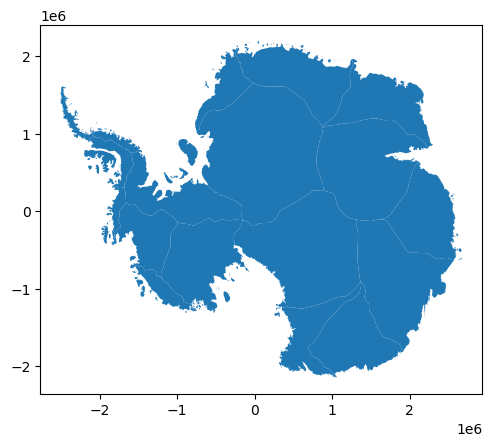

In [3]:
# quick plot
gdf.plot()

In [4]:
# define a useful function (also saved to libs.gdf)
def clip_dataarray_with_shapefile(ds: xr.DataArray, shape: gpd.GeoDataFrame, all_touched: bool = False) -> xr.Dataset:

    """
    Clip an xarray Dataset using a shapefile.

    Parameters:
    - ds: The input xarray Dataset.
    - shape: shapefile as a Geopandas geodataframe.
    - all_touched: whether to clip any cell that touches the shapefile edge

    Returns:
    - An xarray Dataset clipped by the shapefile.
    """
    
    # Convert the dataset to a rioxarray object (if it's not already)
    ds_rio = ds.rio.write_crs(shape.crs.to_string())
        
    # Clip the dataset
    # from rio.clip documentation:
    # all_touched : boolean, optional
    #     If True, all pixels touched by geometries will be burned in.  If
    #     false, only pixels whose center is within the polygon or that
    #     are selected by Bresenham's line algorithm will be burned in.
    ds_clipped = ds_rio.rio.clip(shape.geometry.apply(mapping), all_touched=all_touched)

    # Interpolate back onto the original grid to avoid cropping done by rio.clip
    # Must first take the transpose because the Rignot gdf data is, for some reason,
    # described in (y, x) coordinates instead of (x, y).
    clipped_on_full_grid = ds_clipped.T.interp(coords=ds.coords, method='nearest')

    return clipped_on_full_grid


In [9]:
# Load in ISMIP basin mask – we want the dimensions of our mask to be the same as this
ismip = xr.open_dataset('/Users/jonniebarnsley/data/phd/masks/ISMIP_basins_16km.nc')
x = ismip.x - max(ismip.x)/2 - 4000
y = ismip.y - max(ismip.y)/2 - 4000
Nx, Ny = ismip.mask.shape

In [10]:
# Empty list to store individual basin masks
masks = []

# Iterate over basins using the ID given in the geopandas dataframe
for basin_id in range(19):
    basin = gdf[gdf.index == basin_id]

    # Generate a numpy array the same size as the ismip_16km mask. Start with the array
    # full of integers matching the basin ID, then we will clip it to be the shape of 
    # the basin with NaNs everywhere else
    full_array = np.full((Nx, Ny), basin_id, dtype=float)
    da = xr.DataArray(data=full_array, coords={'x': x, 'y': y}, dims=['x', 'y'])

    # Do the clipping
    basin_mask = clip_dataarray_with_shapefile(da, basin, all_touched=False)
    # Add clipped dataset to list of basin masks 
    masks.append(basin_mask)

# Stitch individual basin masks together. If all_touched=False, then no pixel should lie in
# more than one basin. Use of 'max' here therefore is never actually choosing one basin over
# another. It is just a simple way of joining the datasets.
masks_ds = xr.concat(masks, dim='dummy')
mask = masks_ds.max(dim='dummy')

ds = xr.Dataset({'basins': mask})

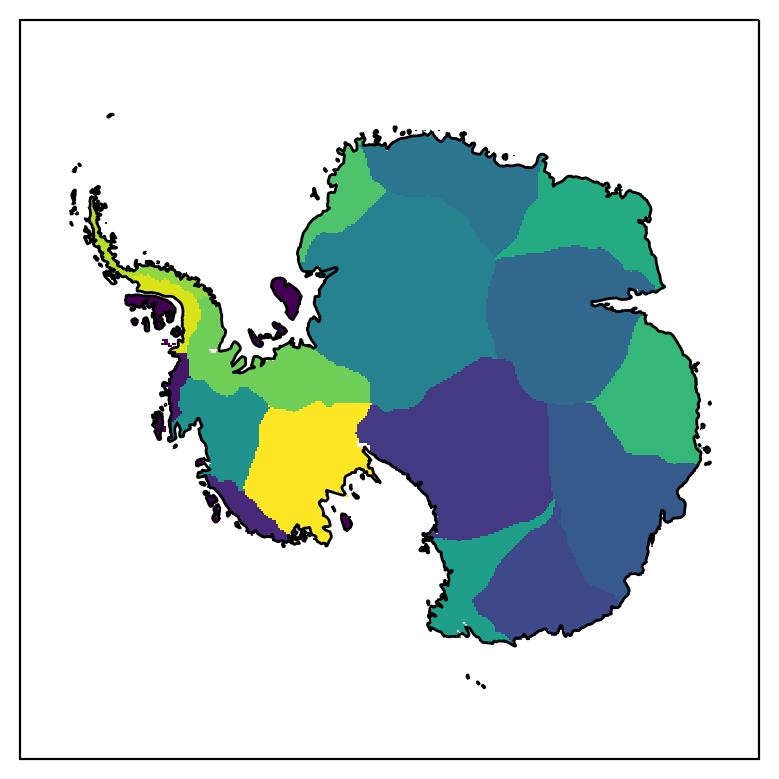

In [14]:
# plot the mask

x = mask.x
y = mask.y

# fig, ax = plt.subplots(dpi=200, )
# ax.pcolormesh(x, y, ds.basins)
# ax.set_aspect('equal')
# ax.set_axis_off()

fig = plt.figure(dpi=200)
ax = plt.axes(projection = ccrs.SouthPolarStereo())

kw = dict(central_latitude=-90, central_longitude=0, true_scale_latitude=-70)
ax.pcolormesh(x, y, ds.basins, transform = ccrs.Stereographic(**kw))

ax.coastlines()

In [15]:
ds

<xarray.Dataset>
Dimensions:      (x: 384, y: 384)
Coordinates:
    spatial_ref  int64 0
  * x            (x) float64 -3.064e+06 -3.048e+06 ... 3.048e+06 3.064e+06
  * y            (y) float64 -3.064e+06 -3.048e+06 ... 3.048e+06 3.064e+06
Data variables:
    basins       (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan

In [16]:
ismip

<xarray.Dataset>
Dimensions:  (x: 384, y: 384)
Coordinates:
  * x        (x) float64 8e+03 2.4e+04 4e+04 ... 6.104e+06 6.12e+06 6.136e+06
  * y        (y) float64 8e+03 2.4e+04 4e+04 ... 6.104e+06 6.12e+06 6.136e+06
Data variables:
    crs      int32 ...
    mask     (y, x) float64 ...
Attributes:
    Conventions:         CF-1.7
    component_0:         mask
    filetype:            VanillaAMRFileType
    crs_EPSG:            0
    num_components:      1
    num_levels:          1
    crs_origin_x:        0.0
    crs_origin_y:        0.0
    dx:                  16000.0
    Conversion_history:  Carried out by J R Barnsley on login2.arc3.leeds.ac....

In [18]:
# Regrid mask to the BISICLES grid 
mask_on_bisicles_grid = ds.drop_vars('spatial_ref').assign_coords(ismip.coords)

# Save mask to file
mask_on_bisicles_grid.to_netcdf('~/data/phd/masks/rignot2_basins_16km.nc')

## Rignot basins on 8km and 1km grid resolutions

In [108]:
x = np.linspace(-3.064e6, 3.072e6, 768)
y = np.linspace(-3.064e6, 3.072e6, 768)

masks = []
for basin_id in range(19):
    basin = gdf[gdf.index == basin_id]
    arr = np.full((Nx*2, Ny*2), basin_id, dtype=float)
    da = xr.DataArray(data=arr, coords={'x': x, 'y':y}, dims=['x', 'y'])
    da = da.rio.write_crs(gdf.crs.to_string())
    clipped = da.rio.clip(basin.geometry.apply(mapping), all_touched=True).T
    da = da.drop_vars('spatial_ref')
    basin_mask = clipped.interp(coords=da.coords, method='nearest')
    masks.append(basin_mask)

masks_ds = xr.concat(masks, dim='dummy')
mask = masks_ds.max(dim='dummy')

clipping basin 0
clipping basin 1
clipping basin 2
clipping basin 3
clipping basin 4
clipping basin 5
clipping basin 6
clipping basin 7
clipping basin 8
clipping basin 9
clipping basin 10
clipping basin 11
clipping basin 12
clipping basin 13
clipping basin 14
clipping basin 15
clipping basin 16
clipping basin 17
clipping basin 18


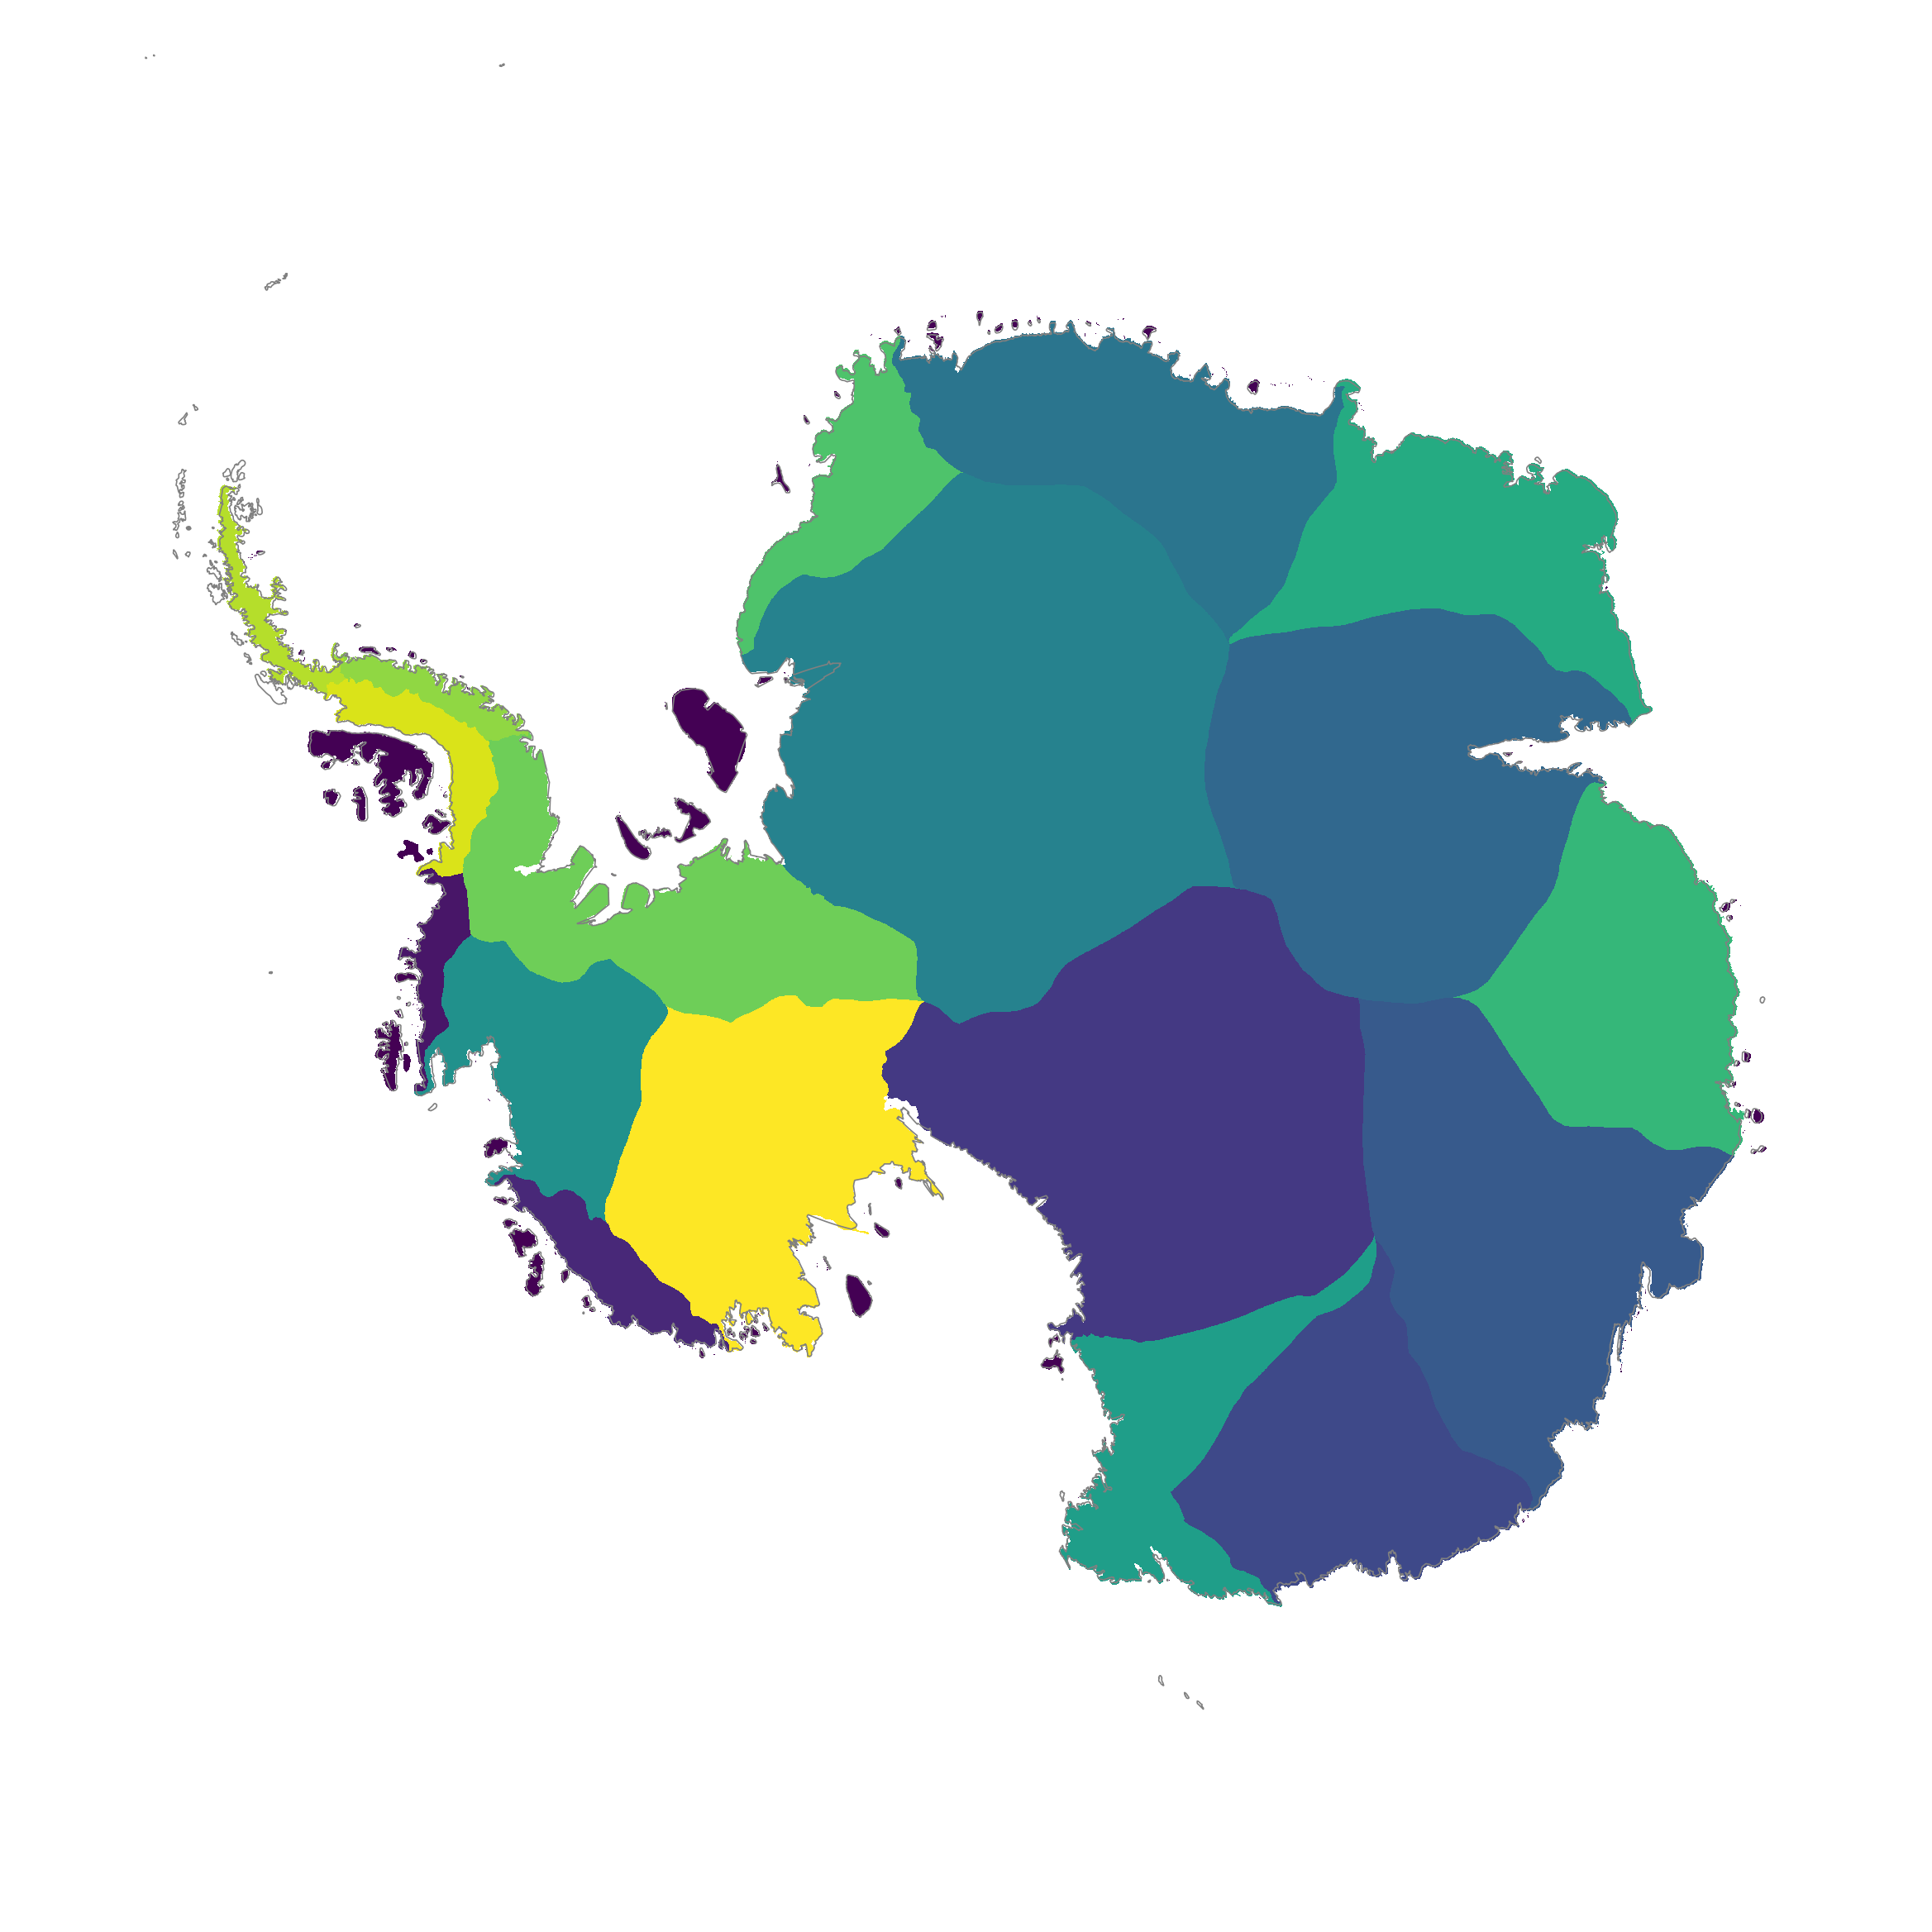

In [38]:
x = np.arange(-3.064e6, 3.065e6, 1000)
y = np.arange(-3.064e6, 3.065e6, 1000)

Nx = len(x)
Ny = len(y)

masks = []
for basin_id in range(19):
    basin = gdf[gdf.index == basin_id]
    arr = np.full((Nx, Ny), basin_id, dtype=float)
    da = xr.DataArray(data=arr, coords={'x': x, 'y':y}, dims=['x', 'y'])
    da = da.rio.write_crs(gdf.crs.to_string())

    print(f'clipping basin {basin_id}')
    clipped = da.rio.clip(basin.geometry.apply(mapping), all_touched=False).T
    da = da.drop_vars('spatial_ref')
    basin_mask = clipped.interp(coords=da.coords, method='nearest')
    masks.append(basin_mask)

masks_ds = xr.concat(masks, dim='dummy')
mask = masks_ds.max(dim='dummy')

x = mask.x
y = mask.y

fig = plt.figure(dpi=200)
ax = plt.axes(projection = ccrs.SouthPolarStereo())

kw = dict(central_latitude=-90, central_longitude=0, true_scale_latitude=-70)
ax.pcolormesh(x, y, mask, transform=ccrs.Stereographic(**kw))
ax.coastlines('10m', lw=0.2, color='grey')

ax.set_aspect('equal')
ax.set_axis_off()